##Import

In [ ]:
import collections
import hashlib
import inspect
import math
import os
import random
import re
import shutil
import sys
import tarfile
import time
import zipfile
import copy
from collections import defaultdict
import pandas as pd
import requests
from IPython import display
from matplotlib import pyplot as plt
#from matplotlib_inline import backend_inline #useful for Jupyter notebooks

d2l = sys.modules[__name__]

import numpy as np
from PIL import Image
from sklearn.metrics import roc_auc_score

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import ConcatDataset
from torchvision import transforms

import warnings

In [ ]:
warnings.filterwarnings('ignore', category=UserWarning)

In [ ]:
accuracies = {}

In [ ]:
noise_level = 0.5

##Auxilliary Classes



###Save hyperparameters

In [ ]:
class HyperParameters:
  def save_hyperparameters(self, ignore=[]):
    """Save function arguments into class attributes."""
    frame = inspect.currentframe().f_back
    _, _, _, local_vars = inspect.getargvalues(frame)
    self.hparams = {k:v for k, v in local_vars.items()
                    if k not in set(ignore+['self']) and not k.startswith('_')}
    for k, v in self.hparams.items():
        setattr(self, k, v)

###Plot

In [ ]:
# def use_svg_display():
#   """Use the svg format to display a plot in Jupyter."""
#   backend_inline.set_matplotlib_formats('svg')

def set_figsize(figsize=(7, 7)):
  """Set the figure size for matplotlib."""
  # use_svg_display()
  d2l.plt.rcParams['figure.figsize'] = figsize

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
  """Set the axes for matplotlib."""
  axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
  axes.set_xscale(xscale), axes.set_yscale(yscale)
  axes.set_xlim(xlim),     axes.set_ylim(ylim)
  if legend:
      axes.legend(legend)
  axes.grid()

def plot(X, Y=None, xlabel=None, ylabel=None, legend=[], xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(7, 7), axes=None):
  """Plot data points."""

  def has_one_axis(X):  # True if `X` (tensor or list) has 1 axis
      return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
              and not hasattr(X[0], "__len__"))

  if has_one_axis(X): X = [X]
  if Y is None:
      X, Y = [[]] * len(X), X
  elif has_one_axis(Y):
      Y = [Y]
  if len(X) != len(Y):
      X = X * len(Y)

  set_figsize(figsize)
  if axes is None: axes = d2l.plt.gca()
  axes.cla()
  for x, y, fmt in zip(X, Y, fmts):
      axes.plot(x,y,fmt) if len(x) else axes.plot(y,fmt)
  set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
  """Plot a list of images."""
  figsize = (num_cols * scale, num_rows * scale)
  _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
  axes = axes.flatten()  
  if imgs.size()[1] == 1:
    imgs = imgs.squeeze(1)
    for i, (ax, img) in enumerate(zip(axes, imgs)):
      try:
          img = d2l.numpy(img)
      except:
          pass
      ax.imshow(img)
      ax.axes.get_xaxis().set_visible(False)
      ax.axes.get_yaxis().set_visible(False)
      if titles:
          ax.set_title(titles[i])
  elif imgs.size()[1] == 3:  
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        try:
            img = d2l.numpy(img)
        except:
            pass
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
  return axes

In [ ]:
class ProgressBoard(HyperParameters):
  """Plot data points in animation."""
  def __init__(self, xlabel=None, ylabel=None, xlim=None,
                ylim=None, xscale='linear', yscale='linear',
                ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                fig=None, axes=None, figsize=(7, 7), display=True):
    self.save_hyperparameters()  

  def draw(self, x, y, label, every_n=1):    
    Point = collections.namedtuple('Point', ['x', 'y'])
    if not hasattr(self, 'raw_points'):
        self.raw_points = collections.OrderedDict()
        self.data = collections.OrderedDict()
    if label not in self.raw_points:
        self.raw_points[label] = []
        self.data[label] = []
    points = self.raw_points[label]
    line = self.data[label]
    points.append(Point(x, y))
    if len(points) != every_n:
        return
    mean = lambda x: sum(x) / len(x)
    line.append(Point(mean([p.x for p in points]),
                      mean([p.y for p in points])))
    points.clear()
    if not self.display:
        return
    # d2l.use_svg_display()
    if self.fig is None:
        self.fig = d2l.plt.figure(figsize=self.figsize)
    plt_lines, labels = [], []
    for (k, v), ls, color in zip(self.data.items(), self.ls, self.colors):
        plt_lines.append(d2l.plt.plot([p.x for p in v], [p.y for p in v],
                                      linestyle=ls, color=color)[0])
        labels.append(k)
    axes = self.axes if self.axes else d2l.plt.gca()
    if self.xlim: axes.set_xlim(self.xlim)
    if self.ylim: axes.set_ylim(self.ylim)
    if not self.xlabel: self.xlabel = self.x
    axes.set_xlabel(self.xlabel)
    axes.set_ylabel(self.ylabel)
    axes.set_xscale(self.xscale)
    axes.set_yscale(self.yscale)
    axes.legend(plt_lines, labels)
    display.display(self.fig)
    display.clear_output(wait=True)

###GPU

In [ ]:
def cpu():    
  return torch.device('cpu')

def gpu(i=0):    
  return torch.device(f'cuda:{i}')

def num_gpus():    
  return torch.cuda.device_count()

def try_gpu(i=0):    
  if num_gpus() >= i + 1:
    return gpu(i)
  return cpu()

def try_all_gpus():    
  return [gpu(i) for i in range(num_gpus())]

##Data related Classes

###DataModule

In [ ]:
class DataModule(HyperParameters):
  def __init__(self, root='./data', num_workers=4):      
    self.save_hyperparameters()

  def _get_dataloader(self, dataset):
    raise NotImplementedError()

  def train_dataloader(self):
    return self._get_dataloader('train')

  def val_dataloader(self):
    return self._get_dataloader('val')

  def test_dataloader(self):
    return self._get_dataloader('test')

In [ ]:
class CIFAR10(DataModule, HyperParameters):
  def __init__(self, transform_func=None, batch_size=64):
    super().__init__()
    self.save_hyperparameters()
    self.train_set = torchvision.datasets.CIFAR10(root=self.root, train=True, transform=transform_func, download=True)    
    self.val_set = torchvision.datasets.CIFAR10(root=self.root, train=False, transform=transform_func, download=True)                

  @property
  def text_labels(self):      
    return self.train_set.classes

  def get_labels(self, indices):
    return [self.text_labels[int(i)] for i in indices]

  # def set_target(self, target):
  #   self.train_set.target_transform = transforms.Lambda(lambda y: (y, target))
  #   self.val_set.target_transform = transforms.Lambda(lambda y: (y, target))

  def _get_dataloader(self, dataset='train'):    
    if dataset == 'train':
      return DataLoader(self.train_set, self.batch_size, shuffle=True, num_workers=self.num_workers)
    elif dataset == 'val':
      return DataLoader(self.val_set, self.batch_size, shuffle=False, num_workers=self.num_workers)

  def visualize(self, batch, nrows=1, ncols=8, labels=[]):
    X, y = batch
    if not labels:
        labels = self.get_labels(y)
    show_images(X, nrows, ncols, titles=labels)    

###True data

In [ ]:
true_transform = transforms.Compose([transforms.Resize(32), transforms.ToTensor()])
true_data = CIFAR10(transform_func=true_transform)

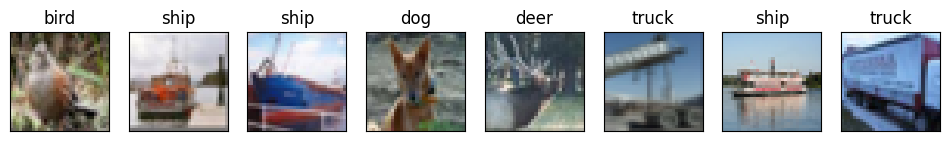

In [ ]:
batch = next(iter(true_data.train_dataloader()))
true_data.visualize(batch)

###Corrupt data

In [ ]:
# A custom transform
class RandomMutilate(object):
  def __init__(self, p=0.5):
    self.p = p

  def __call__(self, img):    
    pixelMap = img.load()           
    if img.mode == 'RGB':
      for i in range(img.size[0]):
        for j in range(img.size[1]):          
            if torch.rand(1) < self.p:              
              pixelMap[i, j] = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    elif img.mode == 'L':
      for i in range(img.size[0]):
        for j in range(img.size[1]):
          if torch.rand(1) < self.p:            
            pixelMap[i, j] = (random.randint(0, 255))            
    return img

  def __repr__(self):
    return 'RandomMutilate'

In [ ]:
corrupt_transform = transforms.Compose([transforms.Resize(32), RandomMutilate(noise_level), transforms.ToTensor()])
corrupt_data = CIFAR10(transform_func=corrupt_transform)

Files already downloaded and verified
Files already downloaded and verified


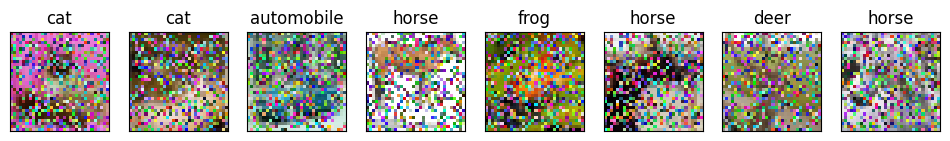

In [ ]:
batch = next(iter(corrupt_data.train_dataloader()))
corrupt_data.visualize(batch)

###Divide data into individual classes

In [ ]:
# Transformations
RS = transforms.Resize(32)
RC = transforms.RandomCrop(32, padding=4)
RHF = transforms.RandomHorizontalFlip()
RVF = transforms.RandomVerticalFlip()
TT = transforms.ToTensor()
TPIL = transforms.ToPILImage()
RM = RandomMutilate(p=0.7)

transform_no_aug = transforms.Compose([TPIL, RS, TT])
transform_corrupt = transforms.Compose([TPIL, RS, RM, TT])

In [ ]:
def get_class_c(x, y, c):    
  y = np.array(y)    
  pos_c = np.argwhere(y == c)    
  pos_c = list(pos_c[:, 0])    
  class_c_data = [(x[i], y[i]) for i in pos_c]
  return class_c_data

In [ ]:
class DatasetMaker(Dataset, HyperParameters):
  def __init__(self, samples, label, transform_func=transform_no_aug, verity=1):
    super().__init__()    
    self.save_hyperparameters()

  def __getitem__(self, i):
    img, label = self.samples[i]
    img = self.transform_func(img)    
    return img, self.verity

  def __len__(self):
    return len(self.samples)


class TestDatasetMaker(DatasetMaker):
  def __init__(self, samples, label, transform_func=transform_no_aug, verity=1):
    super().__init__(samples, label, transform_func, verity)        

  def __getitem__(self, i):
    img, label = self.samples[i]
    img = self.transform_func(img)
    return img, int(label == self.label)

  def __len__(self):
    return len(self.samples)

In [ ]:
def prepare_datasets(true_data, corrupt_data, class_label): 
  # get single class (class_label) data
  true_train_set = get_class_c(true_data.train_set.data, true_data.train_set.targets, class_label)
  true_val_set = get_class_c(true_data.val_set.data, true_data.val_set.targets, class_label)
  corrupt_train_set = get_class_c(corrupt_data.train_set.data, corrupt_data.train_set.targets, class_label)
  corrupt_val_set = get_class_c(corrupt_data.val_set.data, corrupt_data.val_set.targets, class_label)
  
  # change labels to `1` or `0`
  oc_true_train_set = DatasetMaker(true_train_set, class_label)
  oc_true_val_set = DatasetMaker(true_val_set, class_label)
  oc_corrupt_train_set = DatasetMaker(corrupt_train_set, class_label, transform_corrupt, verity=0)
  oc_corrupt_val_set = DatasetMaker(corrupt_val_set, class_label, transform_corrupt, verity=0)

  # concat true and corrupt data
  train_set = ConcatDataset([oc_true_train_set, oc_corrupt_train_set])
  val_set = ConcatDataset([oc_true_val_set, oc_corrupt_val_set])

  # a separate test set to test performance on all classes (even those not seen during training)
  test_set = TestDatasetMaker(list(zip(true_data.val_set.data, true_data.val_set.targets)), class_label)

  return train_set, val_set, test_set

###One Class Data

In [ ]:
class OneClassData(DataModule):
  def __init__(self, true_data, corrupt_data, class_label, batch_size=64):
    super().__init__()
    self.class_name = true_data.text_labels[class_label]
    self.batch_size = batch_size    
    self.train_set, self.val_set, self.test_set = prepare_datasets(true_data, corrupt_data, class_label)    
  
  def _get_dataloader(self, dataset):    
    if dataset == 'train':
      return DataLoader(self.train_set, self.batch_size, shuffle=True, num_workers=self.num_workers)
    elif dataset == 'val':
      return DataLoader(self.val_set, self.batch_size, shuffle=False, num_workers=self.num_workers)
    elif dataset == 'test':
      return DataLoader(self.test_set, self.batch_size, shuffle=False, num_workers=self.num_workers)    

  def visualize(self, batch, nrows=1, ncols=8):
    X, y = batch        
    show_images(X, nrows, ncols, titles=[self.class_name]*len(y))

##Model related classes

In [ ]:
class Module(nn.Module, HyperParameters):
  def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
    super().__init__()
    self.save_hyperparameters()
    self.board = ProgressBoard()
    
  def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), lr=self.learning_rate, momentum=0.9)

  def loss(self, y_hat, y):
    raise NotImplementedError

  def forward(self, X):
    assert hasattr(self, 'net'), 'Neural network is defined'
    return self.net(X)

  def plot(self, key, value, train):
    """Plot a point in animation."""
    assert hasattr(self, 'trainer'), 'Trainer is not inited'
    self.board.xlabel = 'epoch'
    if train:
        x = self.trainer.train_batch_idx / self.trainer.num_train_batches
        n = self.trainer.num_train_batches / self.plot_train_per_epoch
    else:
        x = self.trainer.epoch + 1
        n = self.trainer.num_val_batches / self.plot_valid_per_epoch
    self.board.draw(x, value.detach().cpu().numpy(), ('train_' if train else 'val_') + key, every_n=int(n))

  def training_step(self, batch):
    X, y = batch    
    model = self    
    y_hat = torch.sigmoid(model(X))   
    l = self.loss(y_hat, y)
    self.plot('loss', l, train=True)
    return l

  def validation_step(self, batch):
    X, y = batch    
    model = self        
    y_hat = torch.sigmoid(model(X))
    l = self.loss(y_hat, y)
    self.plot('loss', l, train=False)
    self.plot('acc', self.accuracy(y, y_hat), train=False)
    # print(self.accuracy(y, y_hat))
    return l

  def testing_step(self, batch, correct_preds):
    X, y = batch    
    model = self        
    y_hat = torch.sigmoid(model(X))
    correct_preds.append(sum(self.accuracy(y, y_hat, averaged=False)))
    # self.plot('acc', self.accuracy(y, y_hat), train=False)

In [ ]:
class Classifier(Module):  
  def loss(self, y_hat, y):
    y_hat = y_hat.reshape(y.shape)    
    return F.binary_cross_entropy(y_hat, y.type(y_hat.dtype)) # the function requires `target` to be `float` datatype

  def accuracy(self, y, y_hat, threshold=0.5, averaged=True):      
    y_hat = y_hat.reshape(y.shape)    
    preds = (y_hat >= threshold).type(y.dtype)
    compare = (preds == y).type(torch.float32)
    return compare.mean() if averaged else compare

  def score(self, y, y_hat):
    return roc_auc_score(y.cpu().detach(), y_hat.cpu().detach())

In [ ]:
class MultiLayerPerceptron(Classifier):
  def __init__(self, num_outputs, num_hiddens, learning_rate):
    super().__init__()
    self.save_hyperparameters()    
    self.net = nn.Sequential(nn.Flatten(), *[nn.Sequential(nn.LazyLinear(nh), nn.LeakyReLU()) for nh in num_hiddens], nn.LazyLinear(num_outputs))

  def forward(self, X):
    return self.net(X)

##A trainer class that defines the training methodology

In [ ]:
class Trainer(HyperParameters):
  def __init__(self, max_epochs, num_gpus=0):    
    self.save_hyperparameters()
    self.gpus = [d2l.gpu(i) for i in range(min(num_gpus, d2l.num_gpus()))]

  def prepare_batch(self, batch):    
    if self.gpus:
        batch = [a.to(self.gpus[0]) for a in batch]
    return batch

  def prepare_data(self, data):
    self.train_dataloader = data.train_dataloader()
    self.val_dataloader = data.val_dataloader()
    self.test_dataloader = data.test_dataloader()
    self.num_train_batches = len(self.train_dataloader)
    self.num_val_batches = len(self.val_dataloader) if self.val_dataloader is not None else 0

  def prepare_model(self, model):
    model.trainer = self
    model.board.xlim = [0, self.max_epochs]
    if self.gpus:
      model.to(self.gpus[0])
    self.model = model

  def fit(self, model, data):
    self.prepare_data(data)
    self.prepare_model(model)
    self.optim = model.configure_optimizers()
    self.epoch = 0
    self.train_batch_idx = 0
    self.val_batch_idx = 0
    accs = []
    for self.epoch in range(self.max_epochs):
      self.fit_epoch()
      correct_preds = []
      for batch in self.test_dataloader:
        with torch.no_grad():
          self.model.testing_step(self.prepare_batch(batch), correct_preds)
      epoch_acc = sum(correct_preds)/len(data.test_set)
      print(f'Epoch {self.epoch}:', epoch_acc)
      accs.append(epoch_acc)
    return accs

  def fit_epoch(self):    
    self.model.train()  # initiate training phase
    for batch in self.train_dataloader:      
      loss = self.model.training_step(self.prepare_batch(batch))
      self.optim.zero_grad()
      with torch.no_grad():
        loss.backward()        
        self.optim.step()
      self.train_batch_idx += 1
        
    if self.val_dataloader is None:
      return        
    self.model.eval()   # initiate validation phase
    for batch in self.val_dataloader:
      with torch.no_grad():
        self.model.validation_step(self.prepare_batch(batch))
      self.val_batch_idx += 1

##Experiments

In [ ]:
oc_data = [None]*len(true_data.text_labels) 
models = [None]*len(true_data.text_labels)

In [ ]:
oc_data[0] = OneClassData(true_data, corrupt_data, 0)

###One class data visualization

In [ ]:
# check if corrupt samples have been concatenated or not (in an arbitrarily picked class 0)
# for X, y in oc_data[0].train_dataloader():
#   if any(y == 0):
#     oc_data[0].visualize((X, y))
#     break

In [ ]:
# batch_test = next(iter(oc_data[0].train_dataloader()))
# oc_data[0].visualize(batch_test)

In [ ]:
# batch = next(iter(oc_data[0].val_dataloader()))
# oc_data[0].visualize(batch)

In [ ]:
# batch = next(iter(oc_data[0].test_dataloader()))
# oc_data[0].visualize(batch)

###Model training

Epoch 9: tensor(0.1757, device='cuda:0')


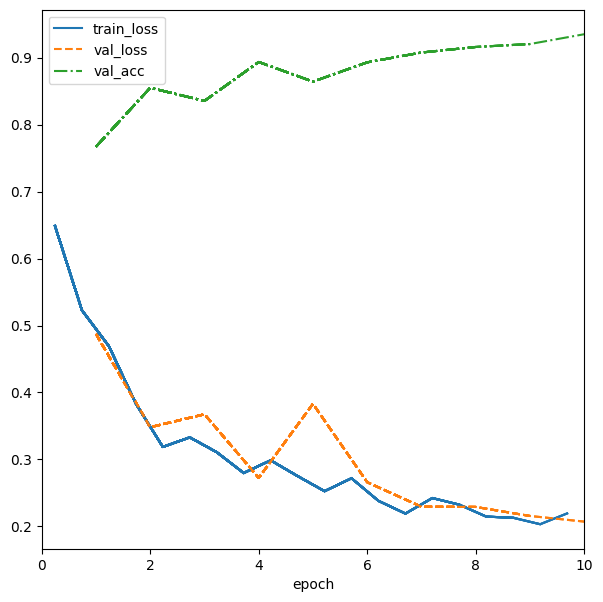

In [ ]:
models[0] = MultiLayerPerceptron(num_outputs=1, num_hiddens=[300, 300], learning_rate=0.01)
trainer = Trainer(max_epochs=10, num_gpus=1)
accs = trainer.fit(models[0], oc_data[0])

In [ ]:
y_test, y_hat_test = [], []
for img, label in oc_data[0].test_dataloader():
  y_test.append(label) 
  y_hat_test.append(torch.sigmoid(models[0].cpu()(img)))

y_test, y_hat_test = torch.cat(y_test), torch.cat(y_hat_test)

In [ ]:
models[0].score(y_test, y_hat_test)

In [ ]:
accuracies[noise_level] = [a.cpu() for a in accs]

In [ ]:
plt.figure(figsize=(7,5))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

for noise, accs in accuracies.items():
  plt.plot(list(range(len(accs))), accs, label=f'{noise}')
  plt.legend()

plt.show()

In [ ]:
accuracies[noise_level]

In [ ]:
torch.min(y_hat_test).item()

In [ ]:
torch.max(y_hat_test).item()

In [ ]:
sum(y_hat_test >= 0.9).item()

In [ ]:
import pandas as pd
import plotly.io as pio
import plotly.express as px

pio.renderers.default = 'colab'

In [ ]:
y_pd = torch.stack([y_test.detach().float(), y_hat_test.squeeze().detach().float()], dim=1)
y_pd.shape

In [ ]:
accs_pd = pd.DataFrame(y_pd, columns=['Ground Truth', 'Predictions'])
accs_pd

In [ ]:
px.scatter(accs_pd, x='Outputs', y=accs_pd.index, color=accs_pd['Ground Truth'].astype(str), opacity=0.7)